<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 8.4: Sentiment Analysis

This lab performs sentiment analysis on sentiment-labelled sentences using two types of feature extraction - a count vectorizer and TF-IDF vectorizer.

Based on the video tutorial **Text Classification with Machine Learning,SpaCy and Scikit(Sentiment Analysis)** by **Jesse E. Agbe (JCharis)**.

## Data Source: UCI
### UCI - Machine Learning Repository
- Center for Machine Learning and Intelligent Systems

The [**UCI Machine Learning Repository**](http://archive.ics.uci.edu/ml/about.html) is a collection of databases, domain theories, and data generators that are used by the machine learning community for the empirical analysis of machine learning algorithms.

### Dataset
- [Sentiment Labelled Sentences Data Set](http://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences)

### Abstract
The dataset contains sentences labelled with positive or negative sentiment.

- Data Set Characteristics: Text
- Number of Instances: 3000
- Area: N/A
- Attribute Characteristics: N/A
- Number of Attributes: N/A
- Date Donated: 2015-05-30
- Associated Tasks: Classification
- Missing Values? N/A

### Source
Dimitrios Kotzias dkotzias '@' ics.uci.edu

### Data Set Information
This dataset was created for the Paper 'From Group to Individual Labels using Deep Features', Kotzias et. al,. KDD 2015

Please cite the paper if you want to use it :)

It contains sentences labelled with positive or negative sentiment.

### Format
sentence &lt;tab&gt; score &lt;newline&gt;

### Details
Score is either 1 (for positive) or 0 (for negative)

The sentences come from three different websites/fields:
- imdb.com
- amazon.com
- yelp.com

For each website, there exist **500 positive** and **500 negative** sentences. Those were selected randomly for larger datasets of reviews.

We attempted to select sentences that have a clearly positive or negative connotation, the goal was for no neutral sentences to be selected.

For the full datasets look:

- **imdb**: Maas et. al., 2011 _Learning word vectors for sentiment analysis_
- **amazon**: McAuley et. al., 2013 _Hidden factors and hidden topics: Understanding rating dimensions with review text_
- **yelp**: [Yelp dataset challenge](http://www.yelp.com/dataset_challenge)


### Attribute Information
The attributes are text sentences, extracted from reviews of products, movies, and restaurants

### Relevant Papers
**From Group to Individual Labels using Deep Features**, Kotzias et. al,. KDD 2015

### Citation Request
**From Group to Individual Labels using Deep Features**, Kotzias et. al,. KDD 2015

## Import libraries

In [1]:
## Import Libraries
import pandas as pd

import regex as re
import spacy

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import warnings
warnings.filterwarnings('ignore')

## Load data

In [2]:
# source is separated by tabs and has no headers
df_yelp = pd.read_csv('../DATA/yelp_labeled.txt', header = None, sep = '\t')
df_imdb = pd.read_csv('../DATA/imdb_labeled_fixed.txt', header = None, sep = '\t') # New file without double quotes
df_amazon = pd.read_csv('../DATA/amazon_cells_labeled.txt', header = None, sep = '\t')
dfs = {'yelp': df_yelp, 'imdb': df_imdb, 'amazon': df_amazon}

## Inspect the data

In [8]:
# - assign column names
# - add the data source
# - check the data
for ds in dfs.keys():
    print('Dataset: %s [%d row(s) x %d col(s)]' % (ds, dfs[ds].shape[0], dfs[ds].shape[1]))
    dfs[ds].columns = ['text', 'sentiment']
    dfs[ds]['source'] = ds
    print(dfs[ds].head())
    print('-' * 75)

Dataset: yelp [1000 row(s) x 2 col(s)]
                                                text  sentiment source
0                           Wow... Loved this place.          1   yelp
1                                 Crust is not good.          0   yelp
2          Not tasty and the texture was just nasty.          0   yelp
3  Stopped by during the late May bank holiday of...          1   yelp
4  The selection on the menu was great and so wer...          1   yelp
---------------------------------------------------------------------------
Dataset: imdb [1000 row(s) x 2 col(s)]
                                                text  sentiment source
0  A very, very, very slow-moving, aimless movie ...          0   imdb
1  Not sure who was more lost - the flat characte...          0   imdb
2  Attempting artiness with black & white and cle...          0   imdb
3       Very little music or anything to speak of.            0   imdb
4  The best scene in the movie was when Gerardo i...          1  

## Merge the data

In [9]:
df = pd.concat(dfs.values(), ignore_index = True)

In [10]:
print('Dataset: %s [%d row(s) x %d col(s)]\n' % ('All', df.shape[0], df.shape[1]))
print(df.info())
print(df.sample(10))
print('-' * 75)

Dataset: All [3000 row(s) x 3 col(s)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       3000 non-null   object
 1   sentiment  3000 non-null   int64 
 2   source     3000 non-null   object
dtypes: int64(1), object(2)
memory usage: 70.4+ KB
None
                                                   text  sentiment  source
2603            I am more than happy with this product.          1  amazon
1589  Beware: this is not a trashy cult movie, this ...          0    imdb
1051  In addition to having one of the most lovely s...          1    imdb
1964  The writer, Gorman Bechard, undoubtedly did hi...          1    imdb
452   I am far from a sushi connoisseur but I can de...          0    yelp
436               definitely will come back here again.          1    yelp
902   The Buffet at Bellagio was far from what I ant...          0    yelp
1649

In [ ]:
df.shape

(3000, 3)

## Prepare the stage
- Load spaCy

In [5]:
nlp = spacy.load('en_core_web_sm')

## Prepare the text
All the text handling and preparation concerned with the changes and modifications from the raw source text to a format that will be used for the actual processing, things like:
- handle encoding
- handle extraneous and international characters
- handle symbols
- handle metadata and embedded information
- handle repetitions (such multiple spaces or newlines)

In [6]:
def clean_text(text):
    # reduce multiple spaces and newlines to only one
    text = re.sub(r'(\s\s+|\n\n+)', r'\1', text)
    # remove double quotes
    text = re.sub(r'"', '', text)

    return text

In [11]:
# Apply the clean_text function to your dataset.
# ANSWER
df['text'] = df['text'].apply(clean_text)

## Work the text
Using techniques learned in previous labs, remove StopWords, punctuation, and digits. Entities can be retained. Return the lemmatized form of any remaining words in lower case form.

This removes meaningless information.


In [15]:
def convert_text(text):
    doc = nlp(text)
    # print(doc.ents)
    # print(type(doc.ents))
    # for x in doc.ents:
    #     print('Named Entity!')
    #     print(x)
    #     print(type(x))
    #     print(x.text)
    #     print(type(x.text))



    entity_list = [entity_span.text for entity_span in doc.ents]
    # print('entity_list')
    # print(entity_list)

    ents = {x.text: x for x in doc.ents}
    # for key, value in ents.items():
    #     print(f"key '{key}' is a {type(key)}; value {value} is a {type(value)}")

    # print()
    tokens = []
    for w in doc:
        # if w.text in entity_list:
        #     print (f"'{w.text}' in entity_list ")
        # else:
        #     print(f'{w} is not in entity_list')
        if w.is_stop or w.is_punct or w.is_digit:
            continue
        if w.text in ents: #this is shorthand for ... in ents.keys()
            # print(f"appending entity {w.text}")
            tokens.append(w.text)
        else:
            tokens.append(w.lemma_.lower())
    text = ' '.join(tokens)

    return text

In [61]:
convert_text("Hello my name is Jennifer Lefeaux and I live in Louisiana")

key 'Jennifer Lefeaux' is a <class 'str'>; value Jennifer Lefeaux is a <class 'spacy.tokens.span.Span'>
key 'Louisiana' is a <class 'str'>; value Louisiana is a <class 'spacy.tokens.span.Span'>

'Louisiana' in entity_list 
appending entity Louisiana


'hello jennifer lefeaux live Louisiana'

It seems that 'Jennifer' and 'Lefeaux' got sent as separate tokens & therefore did not get recognized as Named Entity

In [16]:
%%time
df['short'] = df['text'].apply(convert_text)

CPU times: total: 500 ms
Wall time: 9.26 s


In [17]:
df.sample(10)

,text,sentiment,source,short
2167,The look of it is very sharp and the screen is...,1,amazon,look sharp screen nice clear great graphic
919,"What SHOULD have been a hilarious, yummy Chris...",0,yelp,hilarious yummy christmas eve dinner remember ...
73,"It took over 30 min to get their milkshake, wh...",0,yelp,take min milkshake chocolate milk
2624,All the other cases I've tried normally fall a...,1,amazon,case tried normally fall apart month long haul
2858,"If I take a picture, the battery drops a bar, ...",0,amazon,picture battery drop bar start beep let know d...
2744,If you like a loud buzzing to override all you...,0,amazon,like loud buzzing override conversation phone
2426,"every thing on phone work perfectly, she like it.",1,amazon,thing phone work perfectly like
1014,This is a very right on case movie that delive...,1,imdb,right case movie deliver right face
1243,"The film has great actors, a master director, ...",1,imdb,film great actor master director significant t...
556,AVOID THIS ESTABLISHMENT!,0,yelp,avoid establishment


## Split the dataset

In [18]:
# Features and Labels
X = df['short']
y = df['sentiment']

# Apply a train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Create a Bag-of-Words Model

In [19]:
# create a matrix of word counts from the text
counts = CountVectorizer()

In [20]:
# do the actual counting
A = counts.fit_transform(X_train, y_train)

In [21]:
type(A)

scipy.sparse._csr.csr_matrix

In [ ]:
# What does A look like after BOW?

pd.DataFrame(A.todense(), columns=counts.get_feature_names_out()).head()

,00,10,11,13,15,15pm,17,20th,2mp,30,...,yucky,yukon,yum,yummy,yun,z500a,zero,zillion,zombie,zombiez
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# create a classifier using SVC
classifier = SVC(kernel='linear', probability=True)

In [ ]:
# train the classifier with the training data
classifier.fit(A, y_train)

SVC(kernel='linear', probability=True)

In [ ]:
# do the transformation for the test data
# NOTE: use `transform()` instead of `fit_transform()`
B = counts.transform(X_test)

In [ ]:
# make predictions based on the test data
#predictions = classifier.predict(B.todense())
predictions = classifier.predict(B)

# store probabilities of predictions being 1
#probabilities = classifier.predict_proba(B.todense())[:, 1]
probabilities = classifier.predict_proba(B)[:, 1]

In [ ]:
# check the accuracy
print('Accuracy: %.4f' % accuracy_score(y_test, predictions))

Accuracy: 0.7833


## Repeat using TF-IDF
TF-IDF = Term Frequency - Inverse Document Frequency

In [ ]:
# create a matrix of word counts from the text
# use TF-IDF
tfidf = TfidfVectorizer()
# do the actual counting
A = tfidf.fit_transform(X_train, y_train)

# train the classifier with the training data
classifier.fit(A, y_train)

# do the transformation for the test data
# NOTE: use `transform()` instead of `fit_transform()`
B = tfidf.transform(X_test)

# make predictions based on the test data
predictions = classifier.predict(B)

# store probabilities of predictions being 1
probabilities = classifier.predict_proba(B)[:, 1]

# check the accuracy
print('Accuracy: %.4f' % accuracy_score(y_test, predictions))

Accuracy: 0.7833


In [ ]:
# What does A look like after TF-IDF?

pd.DataFrame(A.todense(), columns=counts.get_feature_names_out()).head()

,00,10,11,13,15,15pm,17,20th,2mp,30,...,yucky,yukon,yum,yummy,yun,z500a,zero,zillion,zombie,zombiez
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Defining a helper function to show results and charts

In [ ]:

def show_summary_report(actual, prediction, probabilities):

    # If actual labels is a Series, extract the array
    if isinstance(actual, pd.Series):
        actual = actual.values
    # If actual and/or prediction labels are strings, convert to integers
    if actual.dtype.name == 'object':
        actual = actual.astype(int)
    if prediction.dtype.name == 'object':
        prediction = prediction.astype(int)

    # Calculate model evaluation metrics
    accuracy_ = accuracy_score(actual, prediction)
    precision_ = precision_score(actual, prediction)
    recall_ = recall_score(actual, prediction)
    roc_auc_ = roc_auc_score(actual, prediction)

    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('ROC AUC  : %.4f                                                                     Best: 1, Worst: < 0.5' % roc_auc_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

    # Confusion Matrix
    mat = confusion_matrix(actual, prediction)

    # Precision/Recall
    precision, recall, _ = precision_recall_curve(actual, probabilities)
    average_precision = average_precision_score(actual, prediction)

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(actual, probabilities)
    roc_auc = auc(fpr, tpr)

    # plot
    fig, ax = plt.subplots(1, 3, figsize = (18, 6))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

    # Plot Confusion Matrix
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Blues', ax = ax[0])

    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('True label')
    ax[0].set_ylabel('Predicted label')

    # Plot Precision/Recall curve
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color = 'b', alpha = 0.2, where = 'post')
    ax[1].fill_between(recall, precision, alpha = 0.2, color = 'b', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-class Precision-Recall curve')

    # Plot ROC curve
    ax[2].plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    ax[2].set_title('Receiver Operating Characteristic')
    ax[2].legend(loc = 'lower right')

    plt.show()

    return (accuracy_, precision_, recall_, roc_auc_)

## Repeating it all for comparison
Repeat the whole lot in one big block using the show_summary_report function.

Find 'Accuracy', 'Precision', 'Recall', 'ROC_AUC' using CountVectorizer and TfidfVectorizer and keep the result in a dataframe.

*********
* Count *
*********
Accuracy : 0.7833 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7959 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7697 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7835                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


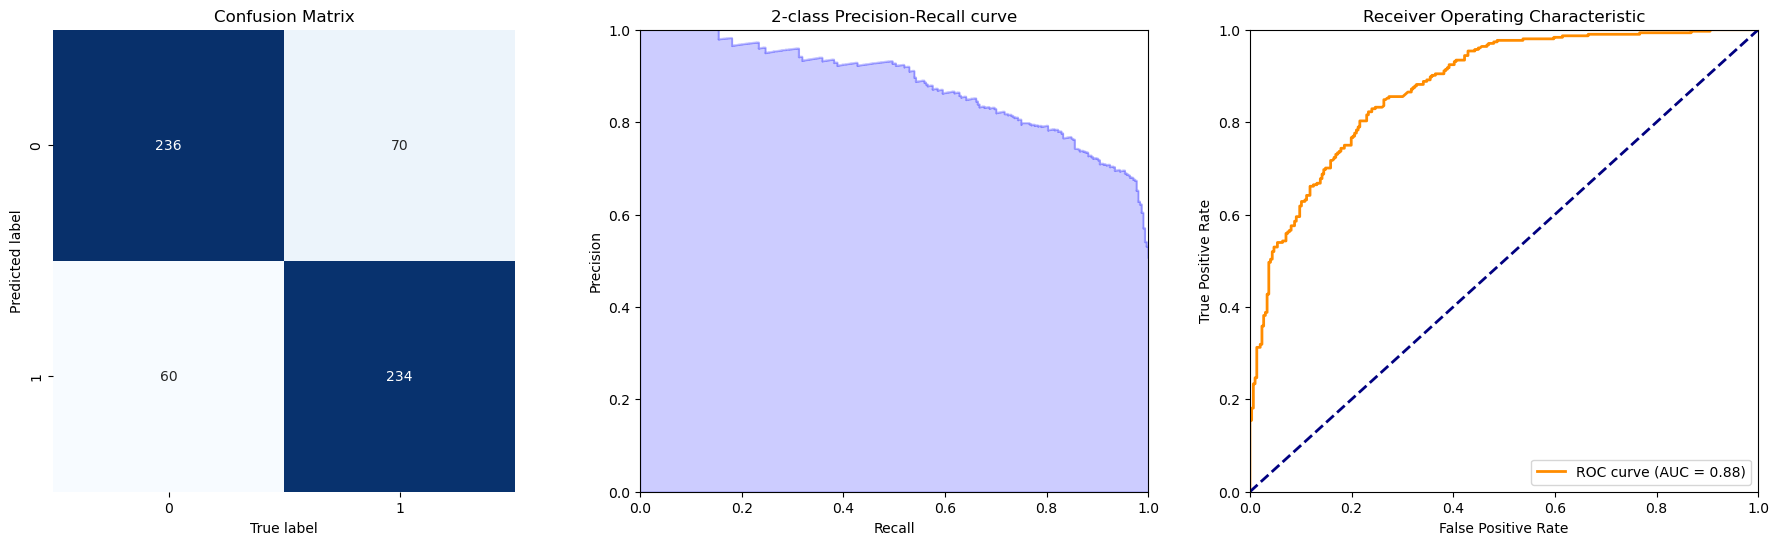

**********
* TF-IDX *
**********
Accuracy : 0.7833 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7939 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7730 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7835                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


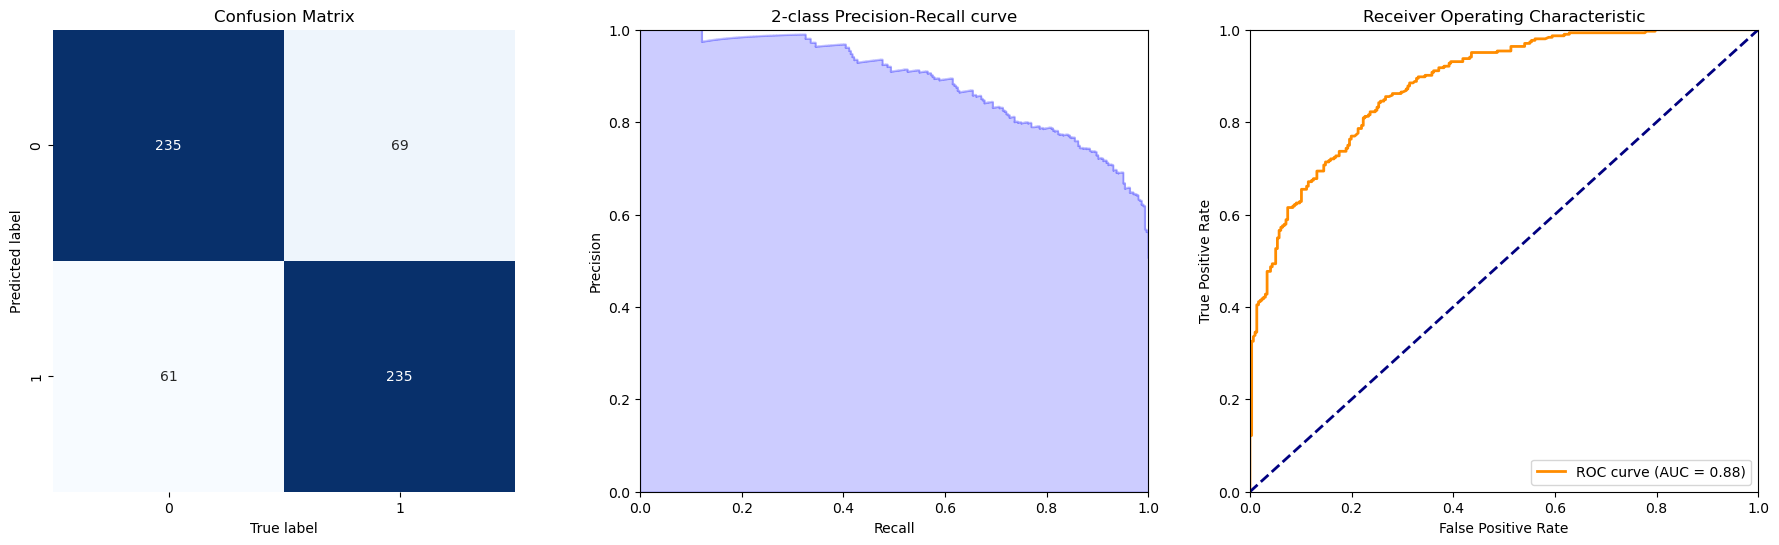

In [ ]:
# Keep the results in a dataframe
results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])

models = ['Count', 'TF-IDX']
for i, m in enumerate([CountVectorizer(), TfidfVectorizer()]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))

    # create a matrix of word counts from the text
    # use TF-IDF
    counts = m
    # do the actual counting
    A = counts.fit_transform(X_train, y_train)

    # create a classifier using SVC
    classifier = SVC(kernel='linear', probability=True)

    # train the classifier with the training data
    classifier.fit(A, y_train)

    # do the transformation for the test data
    # NOTE: use `transform()` instead of `fit_transform()`
    B = counts.transform(X_test)

    # make predictions based on the test data
    predictions = classifier.predict(B)

    # store probabilities of predictions being 1
    probabilities = classifier.predict_proba(B)[:, 1]

    # show the report
    accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_test, predictions, probabilities)
    # keep the results
    results.loc[i] = {'Model': models[i],
                      'Accuracy': accuracy_,
                      'Precision': precision_,
                      'Recall': recall_,
                      'ROC_AUC': roc_auc_}

In [ ]:
# print results dataframe

results

,Model,Accuracy,Precision,Recall,ROC_AUC
0,Count,0.783333,0.795918,0.769737,0.783517
1,TF-IDX,0.783333,0.793919,0.773026,0.783473




---



---



> > > > > > > > > © 2024 Institute of Data


---



---



